In [2]:
import requests as rq
import pandas as pd
import re

In [15]:
urlsessions=r'https://f1.tfeed.net/sessions/eng_sessions.js'

seasons=rq.get(urlsessions)
teams=pd.Series(re.findall("'\d\d','\D+','\d{4}_\D+','.+','(.+)'",seasons.text.replace('\t',''))).unique()
teams_dict={}
for team in teams:
    teams_dict[team]=rq.get('https://f1.tfeed.net/teams/eng_{}.js'.format(team)).text

drivers=pd.Series(re.findall("'\d\d','\D+','\d{4}_\D+','(.+)',.+",seasons.text.replace('\t',''))).unique()
drivers_dict={}
for driver in drivers:
    drivers_dict[driver]=rq.get('https://f1.tfeed.net/drivers/eng_{}.js'.format(driver)).text


races=re.findall('(\d{4}_\D+)\',',seasons.text)
#season data to get combinations of drivers, teams, etc
season_data=re.findall('new Array\((.+)\);',seasons.text.replace('\n',''))
season_data=pd.DataFrame(season_data[0].split('\t'))
season_data[0]=season_data[0].apply(lambda x: re.sub('\)?;.+Array\(','',x))
season_data[0]=season_data[0].apply(lambda x: re.sub('//','',x))

to_drop=season_data[season_data[0]=='']
season_data[0]=season_data[0].drop(to_drop.index)
season_data.dropna(inplace=True)
season_data.reset_index(inplace=True,drop=True)
season_data[0]=season_data[0].str.replace("'","")
season_data=season_data[0].str.split(',',expand=True).drop(columns=[5])
season_data['season']=season_data[3].apply(lambda x: re.findall('(\d{4})',x)[0])
season_data.rename(columns={0:'weekend_num',1:'race_name',2:'session_name',3:'driver_set',4:'team_set'},inplace=True)
season_data['year']=season_data['session_name'].apply(lambda x: re.findall('\d+',x)[0])

In [48]:
season_data['notes']=None
notes_raw=re.findall('notes\[.+\]=.+;',seasons.text.replace('\n',''))[0].split(';')
notes=[]
[notes.append(x) for x in notes_raw if 'notes' in x]

for x in notes:
    test=re.findall("'(\d+)'",x)
    id=season_data.index[(season_data['year']==test[0])&(season_data['weekend_num']==test[1])][0]
    season_data.loc[id,'notes']=re.findall('"(.+)"',x)[0]


In [299]:
urlconfig=r'https://f1.tfeed.net/sessions/config.js?v=10.7'
config_data=rq.get(urlconfig).text.replace('\n','').replace('\t','') 
track_subs_data=pd.DataFrame(re.findall('map_subst\[\'(.+?)\'\]=\'(.+?)\';',config_data)).rename(columns={0:'session_name',1:'track_name'})
season_data=season_data.merge(track_subs_data,how='left',on='session_name')
season_data.fillna({'track_name':season_data['session_name']},inplace=True)

In [44]:
import pickle
dir=r'../data/processed/f1-tfeed'
# save dictionary to session_data.pkl file
with open(dir+r'\team_data.pkl', 'wb') as fp:
    pickle.dump(teams_dict, fp)
    print('dictionary saved successfully to file')
with open(dir+r'\drivers_data.pkl', 'wb') as fp:
    pickle.dump(drivers_dict, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file
dictionary saved successfully to file


In [30]:
import re
#racesx=re.findall('(\d{4}_\D+)\',',x.text)
races=pd.read_csv(r'..\Data\f1-tfeed\season_data.csv')['session_name']
sessions={}

In [297]:
#KALENDER
import json
urlcalendar=r'https://f1.tfeed.net/sessions/2024_calendar.js?'
texts=re.findall('calendar=new Array\((.+);',rq.get(urlcalendar).text.replace('\n','').replace('\t',''))[0]
dfSchedule=pd.DataFrame(re.findall("'(\d+)','(\d+/\d+/\d+)','(\d+:\d+)',cst(Practice|Qualification|Sprint|Race),?",texts))#.drop(0,axis=1)
dfSchedule[1]=dfSchedule[1].str.replace('31/09','30/09')
dfSchedule['TS']=pd.to_datetime(dfSchedule[1]+' '+dfSchedule[2],format='%d/%m/%Y %H:%M').dt.tz_localize(tz='Asia/Bahrain').dt.tz_convert('Asia/Jakarta')

session_names=[]
i=1
for text in dfSchedule[3]:
    
    if text=='Practice':
        session_names.append(text+f'{i}')
        i+=1
    else:
        session_names.append(text)
        i=1
dfSchedule=dfSchedule.merge(pd.DataFrame(session_names),left_index=True,right_index=True)
schedule_data=season_data[season_data['year']=='2024'][['weekend_num','race_name','session_name']].merge(dfSchedule,left_on='weekend_num',right_on='0_x')[['weekend_num','race_name','TS','0_y']].rename(columns={'0_y':'session_type','TS':'timestamp'})

In [88]:
races=season_data['session_name']
sessions={}
from datetime import datetime
now=datetime.now()


for num,formats in enumerate(races):
    if now>pd.to_datetime(schedule_data[(schedule_data['session_name']==formats)&(schedule_data['session_name']=='Race')]['timestamp'].values[0]):
        url=r'https://f1.tfeed.net/sessions/{}/session.js?'.format(formats)
        if (formats not in list(sessions.keys())) and (formats not in ['2021_spa','2023_imola']):
            resp=rq.get(url)
            if resp.status_code!=200:
                i=0 
                while resp.status_code!=200:
                    print(f'Retrying {formats}, trial number {i+1}...')
                    resp=rq.get(url)
                    i+=1
                continue
            sessions[formats]=resp.text
        else: continue
    else: break
        

Retrying 2024_suzuka, trial number 1...
Retrying 2024_suzuka, trial number 2...
Retrying 2024_suzuka, trial number 3...
Retrying 2024_suzuka, trial number 4...
Retrying 2024_suzuka, trial number 5...
Retrying 2024_suzuka, trial number 6...
Retrying 2024_suzuka, trial number 7...
Retrying 2024_suzuka, trial number 8...
Retrying 2024_suzuka, trial number 9...
Retrying 2024_suzuka, trial number 10...
Retrying 2024_suzuka, trial number 11...
Retrying 2024_suzuka, trial number 12...
Retrying 2024_suzuka, trial number 13...
Retrying 2024_suzuka, trial number 14...
Retrying 2024_suzuka, trial number 15...
Retrying 2024_suzuka, trial number 16...
Retrying 2024_suzuka, trial number 17...
Retrying 2024_suzuka, trial number 18...
Retrying 2024_suzuka, trial number 19...
Retrying 2024_suzuka, trial number 20...
Retrying 2024_suzuka, trial number 21...
Retrying 2024_suzuka, trial number 22...
Retrying 2024_suzuka, trial number 23...
Retrying 2024_suzuka, trial number 24...
Retrying 2024_suzuka, tri

KeyboardInterrupt: 

In [34]:
import pickle
dir=r'F:\DataspellProjects\IndonesiaReg\Data\f1-tfeed'
# save dictionary to session_data.pkl file
with open(dir+'\session_data.pkl', 'wb') as fp:
    pickle.dump(sessions, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [35]:
import pickle
dir=r'F:\DataspellProjects\IndonesiaReg\Data\f1-tfeed'
# Read dictionary pkl file
with open(dir+'\session_data.pkl', 'rb') as fp:
    sessions = pickle.load(fp)
    

In [ ]:
import os
import zipfile
from tqdm import tqdm
dir=r'../data/interim/f1-tfeed'

errors=[]
for formats in races:
    retries=0
    
    url=r'https://f1.tfeed.net/sessions/{}/session.zip'.format(formats)
    if os.path.exists(dir+'\{}'.format(formats)):
        continue
    print('\nDownloading '+formats)
    os.mkdir(dir+'\{}'.format(formats))
    while retries<3:
        try:
            print('Download attempt number '+str(retries+1))
            chunkSize = 1024
            r = rq.get(url, stream=True)
            with open(dir+'\{}\session.zip'.format(formats), 'wb') as f:
                pbar = tqdm( unit="B", total=int( r.headers['Content-Length'] ) )
                for chunk in r.iter_content(chunk_size=chunkSize): 
                    if chunk: # filter out keep-alive new chunks
                        pbar.update (len(chunk))
                        f.write(chunk)
            with zipfile.ZipFile(dir+'\{}\session.zip'.format(formats), 'r') as zip_ref:
                print('Extracting zip...')
                for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
                    zip_ref.extract(member=file, path=dir+'\{}'.format(formats))
            break
        except:
            retries+=1
            raise e
    if retries==3:
        print('Download {} failed'.format(formats))
        errors.append(formats)
    else:
        print('Download {} success'.format(formats))

In [ ]:
#todo: process semua link
#https://f1.tfeed.net/sessions/2024_calendar.js? - kalender -DONE
#https://f1.tfeed.net/sessions/config.js?v=10.7 - konfigurasi skor, track, dan rulebook -Nanti aja, bukan prioritas

In [236]:
import numpy as np
#track processing
urlmaps=r'https://f1.tfeed.net/maps/2022_australia.js'
maps_data=rq.get(urlmaps).text.replace('\n','').replace('\t','')
trajectory=re.findall('(\d+),?',re.findall('trajectory=new Array\((.+?)\);',maps_data)[0])
trajectory=np.array(trajectory).astype(int).reshape(-1,2)

sectorStartShift=np.array(re.findall('sectorsStartShift=\[(\d+),(\d+)\];',maps_data)[0]).astype(int).reshape(-1,2)

sectors=re.findall('sectors\[(1|2)\]=new Array\((\d+),(\d+)\);',maps_data)
sectors.insert(0,('0',trajectory[0,0],trajectory[0,1]))

mapLaps=int(re.findall('mapLaps=(\d+);',maps_data)[0])
mapLength=int(re.findall('mapLength=(\d+);',maps_data)[0])
mapCenter=np.array(re.findall('mapCenter=\[(\d+),(\d+)\];',maps_data)[0]).astype(int).reshape(-1,2)
mapNorth=float(re.findall('mapNorth=(\d+\.\d+);',maps_data)[0])
mapName=re.findall('aMapName\[\'eng\'\]=(\'.+\');',maps_data)[0]

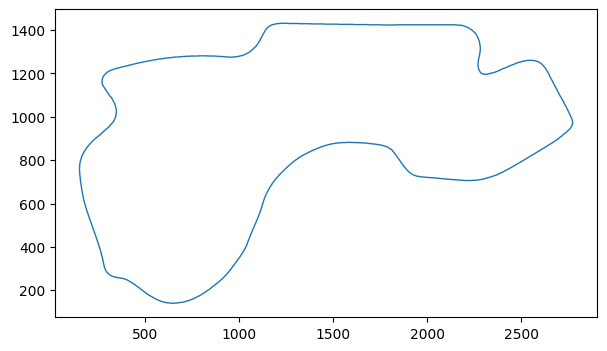

In [243]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(7,4))
ax.plot(trajectory[:-1,0],trajectory[:-1,1],linestyle='-',linewidth=1)